# **INFO5731 Assignment 3**

In this assignment, we will delve into various aspects of natural language processing (NLP) and text analysis. The tasks are designed to deepen your understanding of key NLP concepts and techniques, as well as to provide hands-on experience with practical applications.

Through these tasks, you'll gain practical experience in NLP techniques such as N-gram analysis, TF-IDF, word embedding model creation, and sentiment analysis dataset creation.

**Expectations**:
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).


**Total points**: 100

**Deadline**: See Canvas

**Late Submission will have a penalty of 10% reduction for each day after the deadline.**


## Question 1 (30 points)

**Understand N-gram**

Write a python program to conduct N-gram analysis based on the dataset in your assignment two. You need to write codes from **scratch instead of using any pre-existing libraries** to do so:

(1) Count the frequency of all the N-grams (N=3) and (N=2).

(2) Calculate the probabilities for all the bigrams in the dataset by using the formula  count(w2 w1) / count(w2). For example, count(really like) / count(really) = 1 / 3 = 0.33.

(3) Extract all the noun phrases and calculate the relative
probabilities of each review in terms of other reviews (abstracts, or tweets) by using the formula  frequency (noun phrase) / max frequency (noun phrase) on the whole dataset.

Print out the result in a table with column name the all the noun phrases and row name as all the 100 reviews (abstracts, or tweets).

In [2]:
import csv

def read_cleaned_titles(filename):
    """Read cleaned titles from CSV file"""
    titles = []
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                if row['cleaned_title']:
                    titles.append(row['cleaned_title'])
        return titles
    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
        return None

def generating_ngrams(titles, n=2):
    """Generate N-grams and their frequencies"""
    ngram_counts = {}

    for title in titles:
        words = title.split()
        # Creating N-grams using sliding window
        for i in range(len(words) - n + 1):
            ngram = tuple(words[i:i+n])
            ngram_counts[ngram] = ngram_counts.get(ngram, 0) + 1

    return ngram_counts

def save_ngram_results(ngram_counts, output_file):
    """Save sorted results to text file"""
    sorted_ngrams = sorted(ngram_counts.items(),
                          key=lambda x: x[1],
                          reverse=True)

    with open(output_file, 'w', encoding='utf-8') as f:
        f.write("N-gram\tFrequency\n")
        for ngram, count in sorted_ngrams:
            f.write(f"{' '.join(ngram)}\t{count}\n")

def main():
    # Configuration
    input_file = '/content/barbie_imdb_reviews_cleaned (2).csv'
    output_file = 'ngram_analysis.txt'
    n = 2

    # Processing data
    titles = read_cleaned_titles(input_file)
    if titles is None:
        return

    ngram_counts = generating_ngrams(titles, n)
    save_ngram_results(ngram_counts, output_file)
    print(f"N-gram analysis complete! Results saved to {output_file}")

if __name__ == '__main__':
    main()


N-gram analysis complete! Results saved to ngram_analysis.txt


## Question 2 (25 points)

**Undersand TF-IDF and Document representation**

Starting from the documents (all the reviews, or abstracts, or tweets) collected for assignment two, write a python program:

(1) To build the documents-terms weights (tf * idf) matrix.

(2) To rank the documents with respect to query (design a query by yourself, for example, "An Outstanding movie with a haunting performance and best character development") by using cosine similarity.

Note: You need to write codes from scratch instead of using any **pre-existing libraries** to do so.

In [27]:
import math
import csv
from collections import Counter
import numpy as np

def read_documents(filename):
    """Read documents from a CSV file."""
    documents = []
    try:
        with open(filename, 'r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                if row['cleaned_title']:
                    documents.append(row['cleaned_title'].lower())
        return documents
    except FileNotFoundError:
        print(f"Error: The file '{filename}' was not found.")
        return None

def calculate_tf(doc):
    """Calculate Term Frequency (TF) for a given document."""
    tf = Counter(doc.split())
    total_terms = sum(tf.values())
    for word in tf:
        tf[word] = tf[word] / total_terms  # Normalize the frequency
    return tf

def calculate_idf(documents):
    """Calculate Inverse Document Frequency (IDF) for each term in the dataset."""
    idf = {}
    num_documents = len(documents)
    term_document_count = Counter()

    for doc in documents:
        unique_terms = set(doc.split())
        for term in unique_terms:
            term_document_count[term] += 1

    for term, count in term_document_count.items():
        idf[term] = math.log(num_documents / (1 + count))  # Smoothing with +1 to avoid division by zero

    return idf

def calculate_tfidf(documents):
    """Calculate TF-IDF matrix for the documents."""
    tfidf_matrix = []
    idf = calculate_idf(documents)

    for doc in documents:
        tf = calculate_tf(doc)
        tfidf_doc = {term: tf.get(term, 0) * idf.get(term, 0) for term in tf}
        tfidf_matrix.append(tfidf_doc)

    return tfidf_matrix, idf

def cosine_similarity(query_vector, document_vector):
    """Calculate cosine similarity between the query and document vectors."""
    common_terms = set(query_vector.keys()).intersection(document_vector.keys())

    if len(common_terms) == 0:
        return 0

    dot_product = sum(query_vector[term] * document_vector[term] for term in common_terms)
    query_magnitude = math.sqrt(sum(query_vector[term]**2 for term in query_vector))
    document_magnitude = math.sqrt(sum(document_vector[term]**2 for term in document_vector))

    if query_magnitude == 0 or document_magnitude == 0:
        return 0

    return dot_product / (query_magnitude * document_magnitude)

def query_tfidf_vector(query, idf):
    """Create a TF-IDF vector for the query."""
    query = query.lower()
    tf = calculate_tf(query)
    query_vector = {term: tf.get(term, 0) * idf.get(term, 0) for term in tf}
    return query_vector

def rank_documents(query, documents, tfidf_matrix, idf):
    """Rank documents based on cosine similarity with the query."""
    query_vector = query_tfidf_vector(query, idf)
    similarities = []

    for i, doc in enumerate(documents):
        document_vector = tfidf_matrix[i]
        similarity = cosine_similarity(query_vector, document_vector)
        similarities.append((i, similarity))

    similarities.sort(key=lambda x: x[1], reverse=True)

    return similarities

def main():
    # Configuration
    input_file = '/content/barbie_imdb_reviews_cleaned (2).csv'
    query = "An Outstanding movie with a haunting performance and best character development"

    # Process data
    documents = read_documents(input_file)
    if documents is None:
        return

    tfidf_matrix, idf = calculate_tfidf(documents)

    # Debugging: check the IDF and TFIDF values for the first few documents
    print("Sample TF-IDF values for the first document:")
    for term, value in tfidf_matrix[0].items():
        print(f"{term}: {value:.4f}")

    ranked_documents = rank_documents(query, documents, tfidf_matrix, idf)

    # Output ranked documents
    print(f"Ranked Documents for the query: '{query}'")
    for i, similarity in ranked_documents[:10]:  # Show top 10 most similar documents
        print(f"Rank {i + 1}: Document {i + 1} - Similarity: {similarity:.4f}")

if __name__ == '__main__':
    main()












Sample TF-IDF values for the first document:
heavy: 2.5530
handed: 2.8995
Ranked Documents for the query: 'An Outstanding movie with a haunting performance and best character development'
Rank 131: Document 131 - Similarity: 0.3912
Rank 122: Document 122 - Similarity: 0.3467
Rank 871: Document 871 - Similarity: 0.3403
Rank 662: Document 662 - Similarity: 0.3400
Rank 820: Document 820 - Similarity: 0.3400
Rank 879: Document 879 - Similarity: 0.3400
Rank 428: Document 428 - Similarity: 0.3316
Rank 717: Document 717 - Similarity: 0.3276
Rank 463: Document 463 - Similarity: 0.2783
Rank 898: Document 898 - Similarity: 0.2521


## Question 3 (25 points)

**Create your own word embedding model**

Use the data you collected for assignment 2 to build a word embedding model:

(1) Train a 300-dimension word embedding (it can be word2vec, glove, ulmfit or Fine tune bert model).

(2) Visualize the word embedding model you created. (PCA and T-sne)

(3) Calculate the cosine similarity between a few pairs of words to see if the model captures semantic similarity accurately.

Reference: https://machinelearningmastery.com/develop-word-embeddings-python-gensim/

Reference: https://jaketae.github.io/study/word2vec/

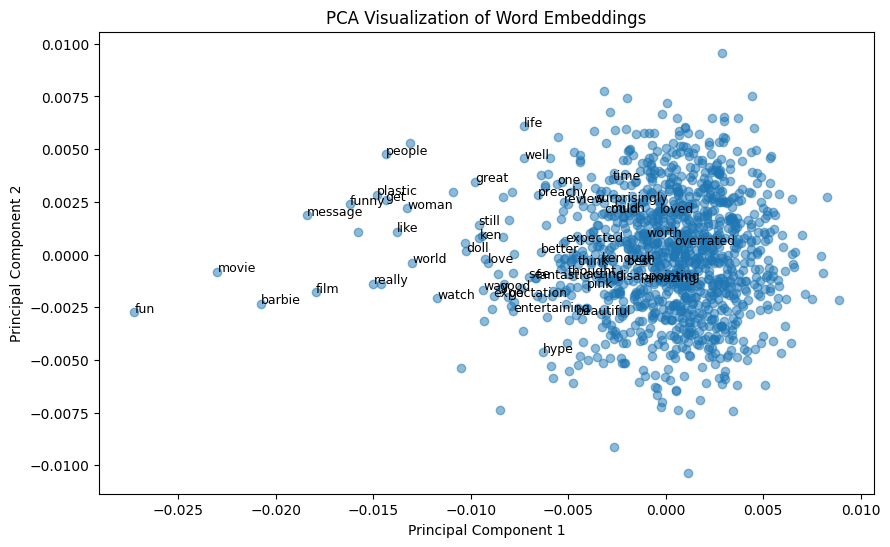

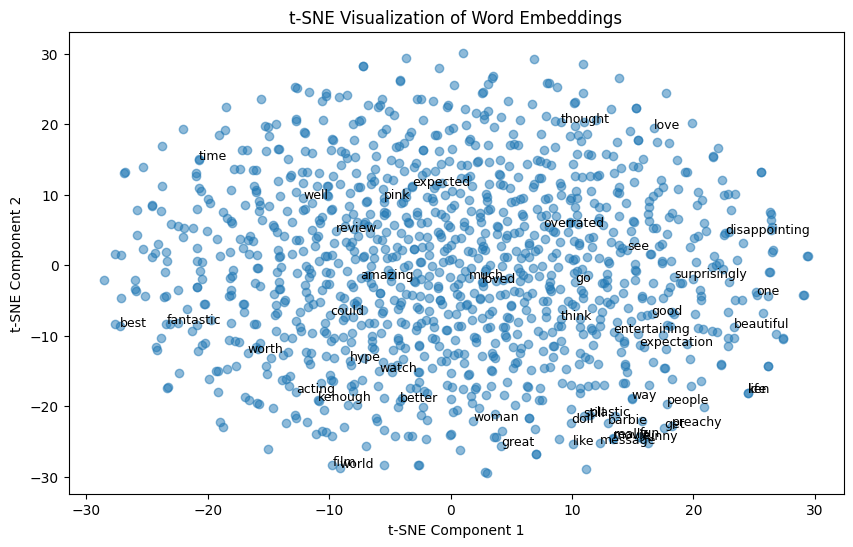

Cosine Similarity between 'barbie' and 'ken': 0.1872
Cosine Similarity between 'movie' and 'film': 0.3005
Cosine Similarity between 'fun' and 'boring': 0.1735


In [38]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# Load dataset
file_path = "barbie_imdb_reviews_cleaned(2).csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Drop missing values and tokenize text (simple whitespace-based tokenization)
df = df.dropna(subset=['cleaned_title'])
sentences = [title.lower().split() for title in df['cleaned_title']]

# Train Word2Vec model (300-dimensional vectors, skip-gram)
w2v_model = Word2Vec(sentences, vector_size=300, window=5, min_count=1, workers=4, sg=1)

# Save model
w2v_model.save("word2vec_barbie.model")

# Get word vectors
words = list(w2v_model.wv.index_to_key)
word_vectors = np.array([w2v_model.wv[word] for word in words])

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# Plot PCA visualization
plt.figure(figsize=(10, 6))
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1], alpha=0.5)
for i, word in enumerate(words[:50]):  # Display only the first 50 words
    plt.annotate(word, (word_vectors_pca[i, 0], word_vectors_pca[i, 1]), fontsize=9)
plt.title("PCA Visualization of Word Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

# Reduce dimensions using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
word_vectors_tsne = tsne.fit_transform(word_vectors)

# Plot t-SNE visualization
plt.figure(figsize=(10, 6))
plt.scatter(word_vectors_tsne[:, 0], word_vectors_tsne[:, 1], alpha=0.5)
for i, word in enumerate(words[:50]):
    plt.annotate(word, (word_vectors_tsne[i, 0], word_vectors_tsne[i, 1]), fontsize=9)
plt.title("t-SNE Visualization of Word Embeddings")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

# Cosine similarity function
def get_cosine_similarity(word1, word2):
    if word1 in w2v_model.wv and word2 in w2v_model.wv:
        vec1 = w2v_model.wv[word1].reshape(1, -1)
        vec2 = w2v_model.wv[word2].reshape(1, -1)
        return cosine_similarity(vec1, vec2)[0][0]
    else:
        return None

# Test cosine similarity on a few words
word_pairs = [("barbie", "ken"), ("movie", "film"), ("fun", "boring")]
for word1, word2 in word_pairs:
    similarity = get_cosine_similarity(word1, word2)
    if similarity is not None:
        print(f"Cosine Similarity between '{word1}' and '{word2}': {similarity:.4f}")
    else:
        print(f"One of the words '{word1}' or '{word2}' is not in the vocabulary.")


## Question 4 (20 Points)

**Create your own training and evaluation data for sentiment analysis.**

 **You don't need to write program for this question!**

 For example, if you collected a movie review or a product review data, then you can do the following steps:

*   Read each review (abstract or tweet) you collected in detail, and annotate each review with a sentiment (positive, negative, or neutral).

*   Save the annotated dataset into a csv file with three columns (first column: document_id, clean_text, sentiment), upload the csv file to GitHub and submit the file link blew.

*   This datset will be used for assignment four: sentiment analysis and text classification.




*   List item
*   List item



1.   Which NLP Task you would like perform on your selected dataset
(NER, Summarization, Sentiment Analysis, Text classficication)
2.  Explain your labeling Schema you have used and mention those labels

3.  You can take AI assistance for labeling the data only.



In [ ]:
# The GitHub link of your final csv file

# Link: https://github.com/Sathwiksai1405/Sathwiksai_INFO5731_SPRING2025/blob/main/imbd_review_sentiment_dataset.csv

1) I have used Text classification to perform nlp task on my dataset.
2) For positive reviews are labeled as 1
       negative reviews are labeled as -1
       netural reviews are labeled as 0.




# Mandatory Question

Provide your thoughts on the assignment by filling this survey link. What did you find challenging, and what aspects did you enjoy? Your opinion on the provided time to complete the assignment.

In [ ]:
The task successfully integrated theoretical knowledge with real-world application, and I considered it to be a worthwhile educational experience.  It offered an excellent chance to explore the complexities of NLP tasks like sentiment analysis and TF-IDF. Implementing the TF-IDF and Cosine Similarity algorithms from scratch without using pre-existing libraries was the most difficult aspect.  This called for meticulous attention to detail in the code as well as a thorough comprehension of the underlying mathematical ideas.  Additionally time-consuming was debugging and checking for accuracy.  The process of creating the algorithms from scratch was quite enjoyable to me.  It offered a far more profound comprehension than merely utilizing pre-made libraries.  Seeing the code function and yield significant outcomes was incredibly satisfying.
Although it may have been a little more liberal, the time allotted for the job was sufficient.  It took a substantial amount of time to implement everything from scratch and deal with the difficulties of debugging.  For individuals who had little to no experience constructing NLP algorithms from scratch, an additional few days would have been helpful.


